In [1]:
import ROOT as rt
import array as array
import os
import glob
from random import gauss
import numpy as np
import root_numpy as rtnpy
import pandas as pd
import h5py
from awkward import JaggedArray, Table
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.insert(0,'/t3home/gelliu/Unfolding_Substructure/CMSSW_10_6_5/python/jetObservables/Unfolding')
import CMS_lumi

Welcome to JupyROOT 6.14/09


In [2]:
lumi=5750+2573+4242+4025+3104+7576+8632
print lumi
CrossSection=np.array([1973000000,117200,7760,642.1,185.9,32.05,9.365,0.8398,0.1124,0.006752,0.0001626])
EventNumber=np.array([3520.33,6875125,4150588,9344512.12,6571952,8456672.59,6680029,831433,692968,834414,11166471])
Scale=lumi*CrossSection/EventNumber
print Scale
MC_Compo=np.array(['QCD Flat','QCD Pt170to300','QCD Pt300to470','QCD Pt470to600','QCD Pt600to800','QCD Pt800to1000','QCD Pt1000to1400','QCD Pt1400to1800','QCD Pt1800to2400','QCD Pt2400to3200','QCD Pt3200toInf'])

35902
[2.01215926e+10 6.12020058e+02 6.71229040e+01 2.46697462e+00
 1.01555547e+00 1.36065230e-01 5.03324507e-02 3.62632943e-02
 5.82333499e-03 2.90515624e-04 5.22785149e-07]


In [3]:
fData=[]
path='/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_JetHTRun2016*.root'
files=glob.glob(path)
for f in files:
    fData.append(f)
print len(fData)
fMC=[
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt-15to7000_TuneCUETP8M1_FlatP6_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_170to300_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_300to470_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_470to600_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_600to800_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_800to1000_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1000to1400_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1400to1800_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_1800to2400_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_2400to3200_TuneCUETP8M1_13TeV_pythia8.root',
    '/t3home/algomez/work/Files/jetObservables/v02/jetObservables_histograms_QCD_Pt_3200toInf_TuneCUETP8M1_13TeV_pythia8.root'
    ]

print len(fMC)

7
11


# Functions to refill histograms to new bins

In [4]:
def Fill1D(h0,h,bins):
    N=h0.GetNbinsX()
    content=np.zeros((len(bins)-1),dtype=float)
    for i in range(len(bins)-1):
        content[i]=0
    for i in range(N):
        center=h0.GetBinCenter(i+1)
        index=np.digitize(np.array([center]),bins)
        if index[0] < len(bins):
            content[index[0]-1]+=h0.GetBinContent(i+1)
    for i in range(len(bins)-1):
        h.SetBinContent(i+1,content[i])

def Fill2D(h0,h,binx,biny):
    Nx=h0.GetNbinsX()
    Ny=h0.GetNbinsY()
    hx=h0.ProjectionX()
    hy=h0.ProjectionY()
    content=np.zeros((len(binx)-1,len(biny)-1),dtype=float)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            content[i][j]=0
    for i in range(Nx):
        for j in range(Ny):
            centerx=hx.GetBinCenter(i+1)
            indexx=np.digitize(np.array([centerx]),binx)
            centery=hy.GetBinCenter(j+1)
            indexy=np.digitize(np.array([centery]),biny)
            if indexx[0] < len(binx) and indexy[0] < len(biny):
                content[indexx[0]-1][indexy[0]-1]+=h0.GetBinContent(i+1,j+1)
    for i in range(len(binx)-1):
        for j in range(len(biny)-1):
            h.SetBinContent(i+1,j+1,content[i][j])

# Purity and stability calculation

In [5]:
def PurityStability(h0,bins):
    
    h=rt.TH2D("",";;",bins.shape[0]-1,(bins),bins.shape[0]-1,(bins))
    Fill2D(h0,h,bins,bins)
    hx=h.ProjectionX()
    hy=h.ProjectionY()
    N=hx.GetNbinsX()
    
    nreco_pergenbin=[]
    nreco_genanywhere=[]
    ngen_recoanywhere=[]
    for i in range(N):
        nreco_pergenbin.append(h.GetBinContent(i+1,i+1))
        nreco_genanywhere.append(hy.GetBinContent(i+1))
        ngen_recoanywhere.append(hx.GetBinContent(i+1))
    nreco_pergenbin=np.array(nreco_pergenbin)
    nreco_genanywhere=np.array(nreco_genanywhere)
    ngen_recoanywhere=np.array(ngen_recoanywhere)
    
    purity_arr=1.0*nreco_pergenbin/nreco_genanywhere
    stability_arr=1.0*nreco_pergenbin/ngen_recoanywhere
    
    purity=rt.TH1D("Purity",";;",bins.shape[0]-1,(bins))
    stability=rt.TH1D("Stability",";;",bins.shape[0]-1,(bins))
    
    for i in range(N):
        purity.SetBinContent(i+1,purity_arr[i])
        stability.SetBinContent(i+1,stability_arr[i])
    
    purity.SetLineWidth(2)
    purity.SetLineStyle(2)
    stability.SetLineWidth(2)
    stability.SetLineStyle(2)
    
    return purity,stability

# Do unfolding

In [6]:
def DoUnfolding(Response,Data_reco,MC_reco,MC_gen,HSname,MCname,gen_bins):
    
    tunfolderMC = rt.TUnfoldDensity(Response,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfold.kRegModeCurvature, rt.TUnfold.kEConstraintNone, rt.TUnfoldDensity.kDensityModeBinWidth)
    tunfolderMC.SetInput(MC_reco)
    MC_unfolded=tunfolderMC.DoUnfold(0.)
    MC_unfolded=tunfolderMC.GetOutput("MC_unfolded")
    
    tunfolderData = rt.TUnfoldDensity(Response,rt.TUnfold.kHistMapOutputHoriz,rt.TUnfold.kRegModeCurvature, rt.TUnfold.kEConstraintNone, rt.TUnfoldDensity.kDensityModeBinWidth)
    tunfolderData.SetInput(Data_reco)
    Data_unfolded=tunfolderData.DoUnfold(0.)
    Data_unfolded=tunfolderData.GetOutput("Data_unfolded")
    
    MC_unfolded.SetMarkerStyle(2)
    MC_unfolded.SetMarkerColor(7)
    MC_unfolded.SetLineColor(7)
    MC_unfolded.SetLineWidth(1)
    
    Data_unfolded.SetMarkerStyle(22)
    Data_unfolded.SetMarkerColor(1)
    Data_unfolded.SetLineColor(1)
    Data_unfolded.SetLineWidth(2)
    
    MC_gen.SetMarkerStyle(5)
    MC_gen.SetMarkerColor(2)
    MC_gen.SetLineColor(2)
    
    ratio=rt.TH1D("Ratios "+HSname,"Ratios "+HSname+";"+HSname+";#frac{MC_unfolded}{MC_gen} ("+MCname+")",gen_bins.shape[0]-1,(gen_bins))
    ratio.Add(MC_unfolded)
    ratio.Divide(MC_gen)
    ratio.SetStats(0)
    ratio.SetMarkerStyle(5)
    ratio.SetMarkerColor(rt.kRed)
    ratio.SetLineColor(rt.kRed)
    ratio.GetYaxis().SetRangeUser(0.5,1.5)
    
    hs=rt.THStack(HSname,HSname)
    hs.Add(MC_unfolded,"E")
    hs.Add(MC_gen,"Hist")
    hs.Add(Data_unfolded,"E")
    
    leg=rt.TLegend(0.5, 0.5, 0.9, 0.8)
    #leg.SetTextSize(6)
    leg.AddEntry(Data_unfolded,"Data_unfolded",'p')
    leg.AddEntry(MC_unfolded,"MC_unfolded ("+MCname+")", 'p')
    leg.AddEntry(MC_gen,"MC_gen ("+MCname+")", 'f')
    leg.SetLineColor(0)
    leg.SetBorderSize(0)
    leg.SetFillStyle(0)
    
    return hs,ratio,leg

# $\tau_1^{(0.5)}$

In [7]:
reco='recoJet_tau_0p5_0_nom_dijetSel'
gen='genJet_tau_0p5_0_dijetSel'
response='respJet_tau_0p5_0_nom_dijetSel'

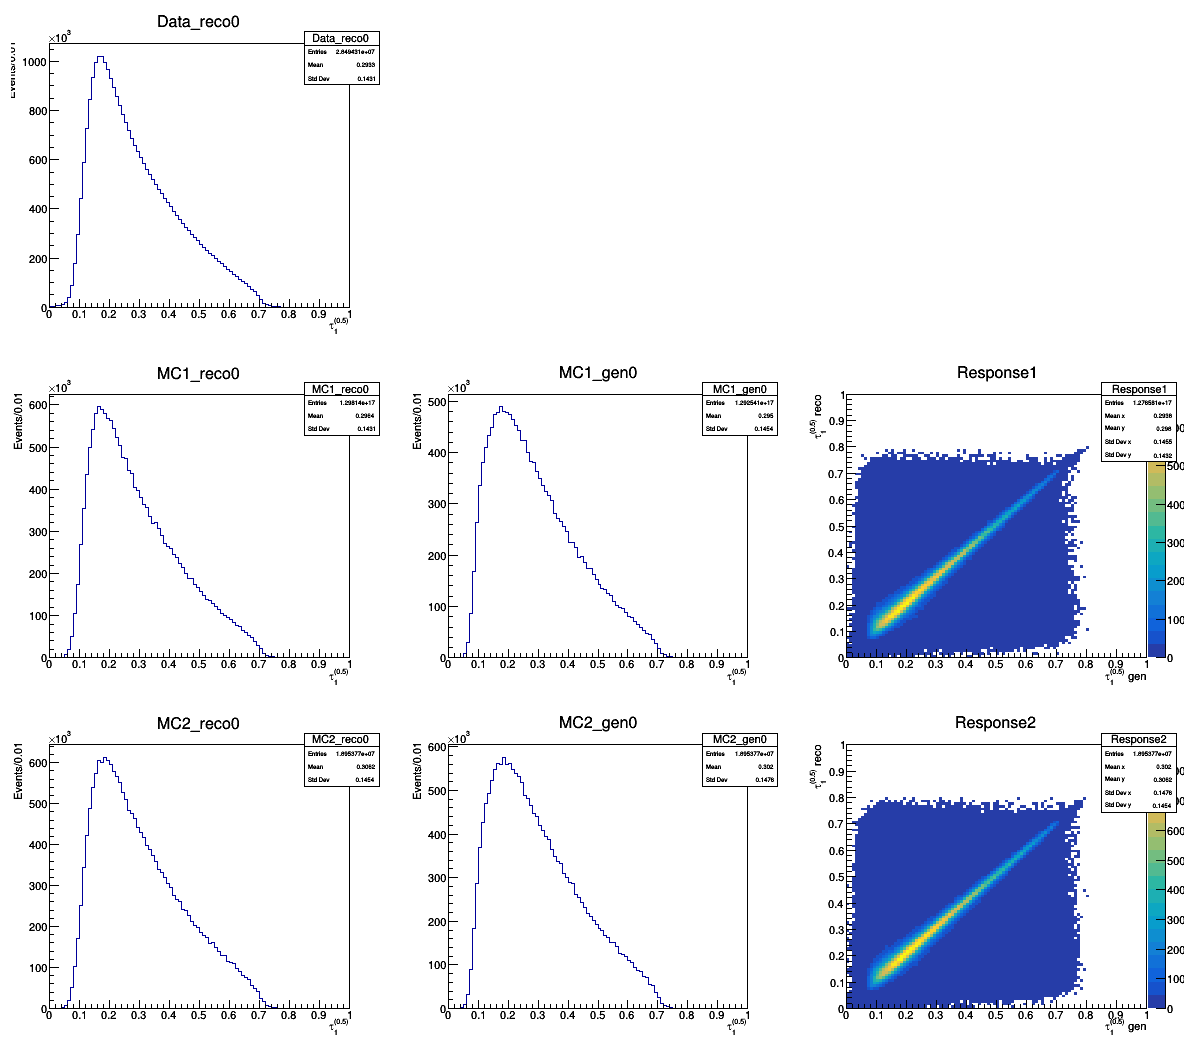

In [8]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{1}^{(0.5)};Events/0.01",100,0,1)
MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{1}^{(0.5)};Events/0.01",100,0,1)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{1}^{(0.5)};Events/0.01",100,0,1)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{1}^{(0.5)};Events/0.01",100,0,1)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{1}^{(0.5)};Events/0.01",100,0,1)
Response1_0=rt.TH2D("Response1","Response1;#tau_{1}^{(0.5)} gen;#tau_{1}^{(0.5)} reco",100,0,1,100,0,1)
Response2_0=rt.TH2D("Response2","Response2;#tau_{1}^{(0.5)} gen;#tau_{1}^{(0.5)} reco",100,0,1,100,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    hist=rt.TH1D("",";;",20,0,1)
    Data_reco0.Add(t.Get(reco))
    f_Data[i].Close()

f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
MC1_reco0.Add(t.Get(reco),Scale[i])
MC1_gen0.Add(t.Get(gen),Scale[i])
Response1_0.Add(t.Get(response),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    #MC2_reco0.Add(t.Get(reco),Scale[i])
    #MC2_gen0.Add(t.Get(gen),Scale[i])
    MC2_reco0.Add(t.Get(response).ProjectionY(),Scale[i])
    MC2_gen0.Add(t.Get(response).ProjectionX(),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,1080)
c0.Divide(3,3)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(4)
MC1_reco0.Draw("hist")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.cd(6)
Response1_0.Draw("Colz")
c0.cd(7)
MC2_reco0.Draw("hist")
c0.cd(8)
MC2_gen0.Draw("hist")
c0.cd(9)
Response2_0.Draw("Colz")
c0.Draw()

In [9]:
for i in range(MC2_reco0.GetNbinsX()):
    print Response2_0.ProjectionX().GetBinCenter(i+1),Response2_0.ProjectionX().GetBinContent(i+1),Response2_0.ProjectionY().GetBinContent(i+1)

0.005 34.6506129881 109.318023909
0.015 48.0614286893 98.4078752633
0.025 772.363127469 1034.77125575
0.035 373.243117911 522.008252775
0.045 1448.07488131 2063.12412648
0.055 8740.30754059 6409.33473983
0.065 32252.7906573 19918.7849521
0.075 88905.1749478 50349.4552118
0.085 182504.142084 102197.536243
0.095 286575.972963 170882.706336
0.105 368804.149291 251763.495136
0.115 426509.797745 343100.607954
0.125 469513.465803 422205.514167
0.135 494036.800029 488034.925047
0.145 522932.428402 539105.864012
0.155 549119.290105 574349.778678
0.165 561343.185856 604102.017052
0.175 559176.60319 599895.523862
0.185 575993.436489 612936.081939
0.195 559390.451144 605463.913205
0.205 561118.731302 594333.949524
0.215 548149.268627 578561.435979
0.225 538552.848452 567033.425004
0.235 531666.006869 551283.765565
0.245 518000.01932 527757.643464
0.255 487517.364029 510191.776992
0.265 482436.319378 483961.883198
0.275 465274.904096 476024.679696
0.285 447454.685367 462767.453835
0.295 440431.146

# Different bins

In [86]:
gen_bins=[]
reco_bins=[]

gen_bins1=np.array([x for x in np.linspace(num=6,start=0.,stop=0.6)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.81])))
reco_bins1=np.array([x for x in np.linspace(num=11,start=0.,stop=0.6)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.7,0.81])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=8,start=0.,stop=0.7)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.81])))
reco_bins1=np.array([x for x in np.linspace(num=15,start=0.,stop=0.7)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.75,0.81])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=10,start=0.,stop=0.72)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.81])))
reco_bins1=np.array([x for x in np.linspace(num=19,start=0.,stop=0.72)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.76,0.81])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=11,start=0.12,stop=0.72)])
gen_bins1=np.concatenate((np.array([0.]),gen_bins1,np.array([0.81])))
reco_bins1=np.array([x for x in np.linspace(num=21,start=0.12,stop=0.72)])
reco_bins1=np.concatenate((np.array([0.,0.06]),reco_bins1,np.array([0.76,0.81])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)
print(",".join(str(i) for i in gen_bins1))
print(",".join(str(i) for i in reco_bins1))

gen_bins1=np.array([x for x in np.linspace(num=19,start=0.,stop=0.72)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.81])))
reco_bins1=np.array([x for x in np.linspace(num=37,start=0.,stop=0.72)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.76,0.81])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

Colors=[rt.kRed,rt.kPink+9,rt.kYellow-7,rt.kSpring-9,rt.kAzure+8,rt.kBlue]

[0.   0.12 0.24 0.36 0.48 0.6  0.81] 6
[0.   0.06 0.12 0.18 0.24 0.3  0.36 0.42 0.48 0.54 0.6  0.7  0.81] 12
[0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.81] 8
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.81] 16
[0.   0.08 0.16 0.24 0.32 0.4  0.48 0.56 0.64 0.72 0.81] 10
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.52
 0.56 0.6  0.64 0.68 0.72 0.76 0.81] 20
[0.   0.12 0.18 0.24 0.3  0.36 0.42 0.48 0.54 0.6  0.66 0.72 0.81] 12
[0.   0.06 0.12 0.15 0.18 0.21 0.24 0.27 0.3  0.33 0.36 0.39 0.42 0.45
 0.48 0.51 0.54 0.57 0.6  0.63 0.66 0.69 0.72 0.76 0.81] 24
0.0,0.12,0.18,0.24,0.3,0.36,0.42,0.48,0.54,0.6,0.66,0.72,0.81
0.0,0.06,0.12,0.15,0.18,0.21,0.24,0.27,0.3,0.32999999999999996,0.36,0.39,0.42,0.44999999999999996,0.48,0.51,0.54,0.57,0.6,0.63,0.66,0.69,0.72,0.76,0.81
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.52
 0.56 0.6  0.64 0.68 0.72 0.81] 19
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.2

In [27]:
hist_purities=[]
hist_stabilities=[]
stack_unfoldings=[]
ratio_unfoldings=[]

responses=[]

c=rt.TCanvas()
stack_purities=rt.THStack("purities","purities")
stack_stabilities=rt.THStack("stabilities","stabilities")

leg_unfoldings=[]
leg_purities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_purities.SetLineColor(0)
leg_purities.SetBorderSize(0)
leg_purities.SetFillStyle(0)
leg_stabilities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_stabilities.SetLineColor(0)
leg_stabilities.SetBorderSize(0)
leg_stabilities.SetFillStyle(0)

for i in range(len(gen_bins)):
    gen_bin=gen_bins[i]
    reco_bin=reco_bins[i]
    print "for binning %d"%(i+1)
    print gen_bin
    
    Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{1}^{(0.5)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_reco=rt.TH1D("MC_reco (QCD)","MC2_reco (QCD);#tau_{1}^{(0.5)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_gen=rt.TH1D("MC_gen (QCD)","MC_gen (QCD);#tau_{1}^{(0.5)};Events",gen_bin.shape[0]-1,gen_bin)
    Response2=rt.TH2D("Response Matrix (QCD)","Response Matrix (QCD);#tau_{1}^{(0.5)} gen;#tau_{1}^{(0.5)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    
    Fill1D(Data_reco0,Data_reco,reco_bin)
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    Fill2D(Response2_0,Response2,gen_bin,reco_bin)

    Response2.SetTitle("Response Matrix #tau_{1}^{(0.5)} binning %d"%(i+1))
    Response2.SetStats(0)
    responses.append(Response2)
    
    purity,stability=PurityStability(Response2_0,gen_bin)
    
    purity.SetTitle("purity %d"%(i+1))
    stability.SetTitle("stability %d"%(i+1))
    purity.SetLineColor(Colors[i])
    stability.SetLineColor(Colors[i])
    hist_purities.append(purity)
    hist_stabilities.append(stability)
    stack_purities.Add(purity)
    stack_stabilities.Add(stability)
    leg_purities.AddEntry(purity,"binning %d"%(i+1))
    leg_stabilities.AddEntry(stability,"binning %d"%(i+1))
    
    Data_reco.Scale(1.0/Data_reco.Integral())
    MC2_reco.Scale(1.0/MC2_reco.Integral())
    MC2_gen.Scale(1.0/MC2_gen.Integral())
    
    hs,ratio,leg=DoUnfolding(Response2,Data_reco,MC2_reco,MC2_gen,"#tau_{1}^{(0.5)}","QCD",gen_bin)
    
    hs.SetTitle("#tau_{1}^{(0.5)} binning %d"%(i+1))
    ratio.SetTitle("Ratios binning %d"%(i+1))
    stack_unfoldings.append(hs)
    ratio_unfoldings.append(ratio)
    leg_unfoldings.append(leg)

for binning 1
[0.   0.12 0.24 0.36 0.48 0.6  0.81]
for binning 2
[0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.81]
for binning 3
[0.   0.08 0.16 0.24 0.32 0.4  0.48 0.56 0.64 0.72 0.81]
for binning 4
[0.   0.12 0.18 0.24 0.3  0.36 0.42 0.48 0.54 0.6  0.66 0.72 0.81]
for binning 5
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.52
 0.56 0.6  0.64 0.68 0.72 0.81]


Warning in <TROOT::Append>: Replacing existing TH1: Data_reco (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_reco (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_gen (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response Matrix (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Purity (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Stability (Potential memory leak).
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 12 input bins and 6 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{1}^{(0.5)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #7 (xaxis:#tau_{1}^{(0.5)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 d

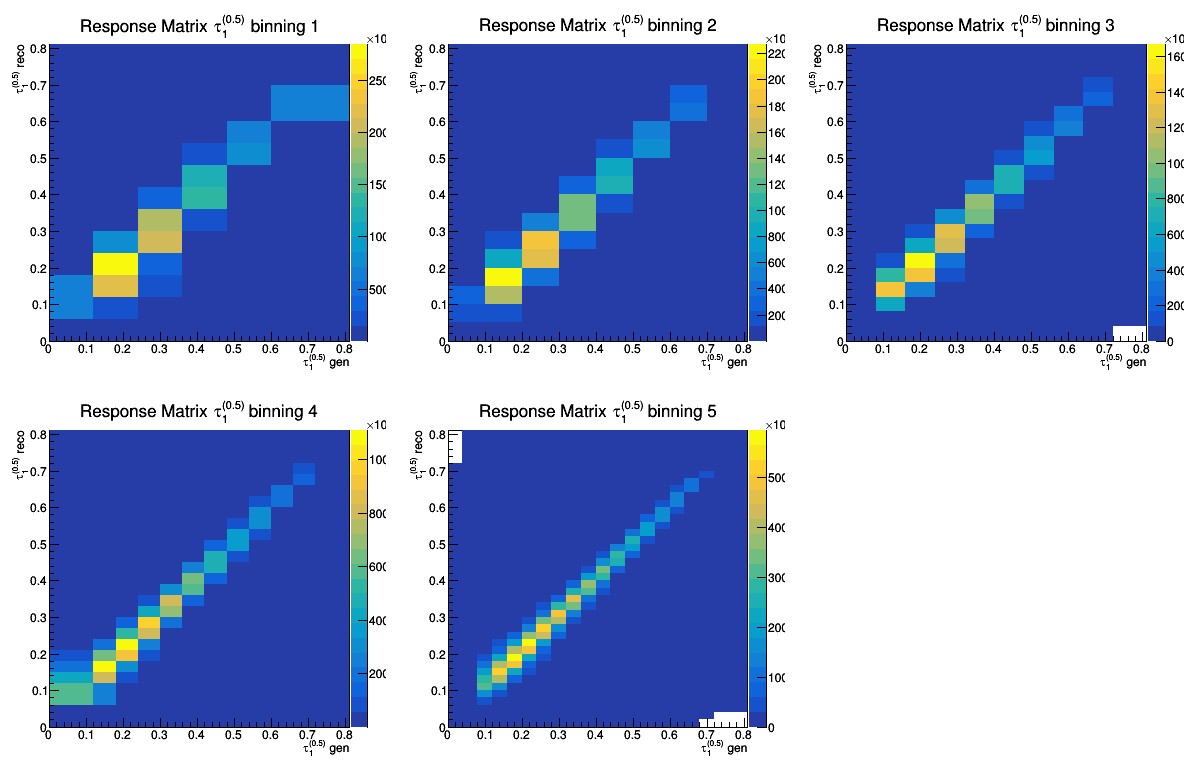

In [28]:
c=rt.TCanvas("","",0,0,1200,800)
c.Divide(3,2)
for i in range(len(gen_bins)):
    c.cd(i+1)
    responses[i].Draw("Colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


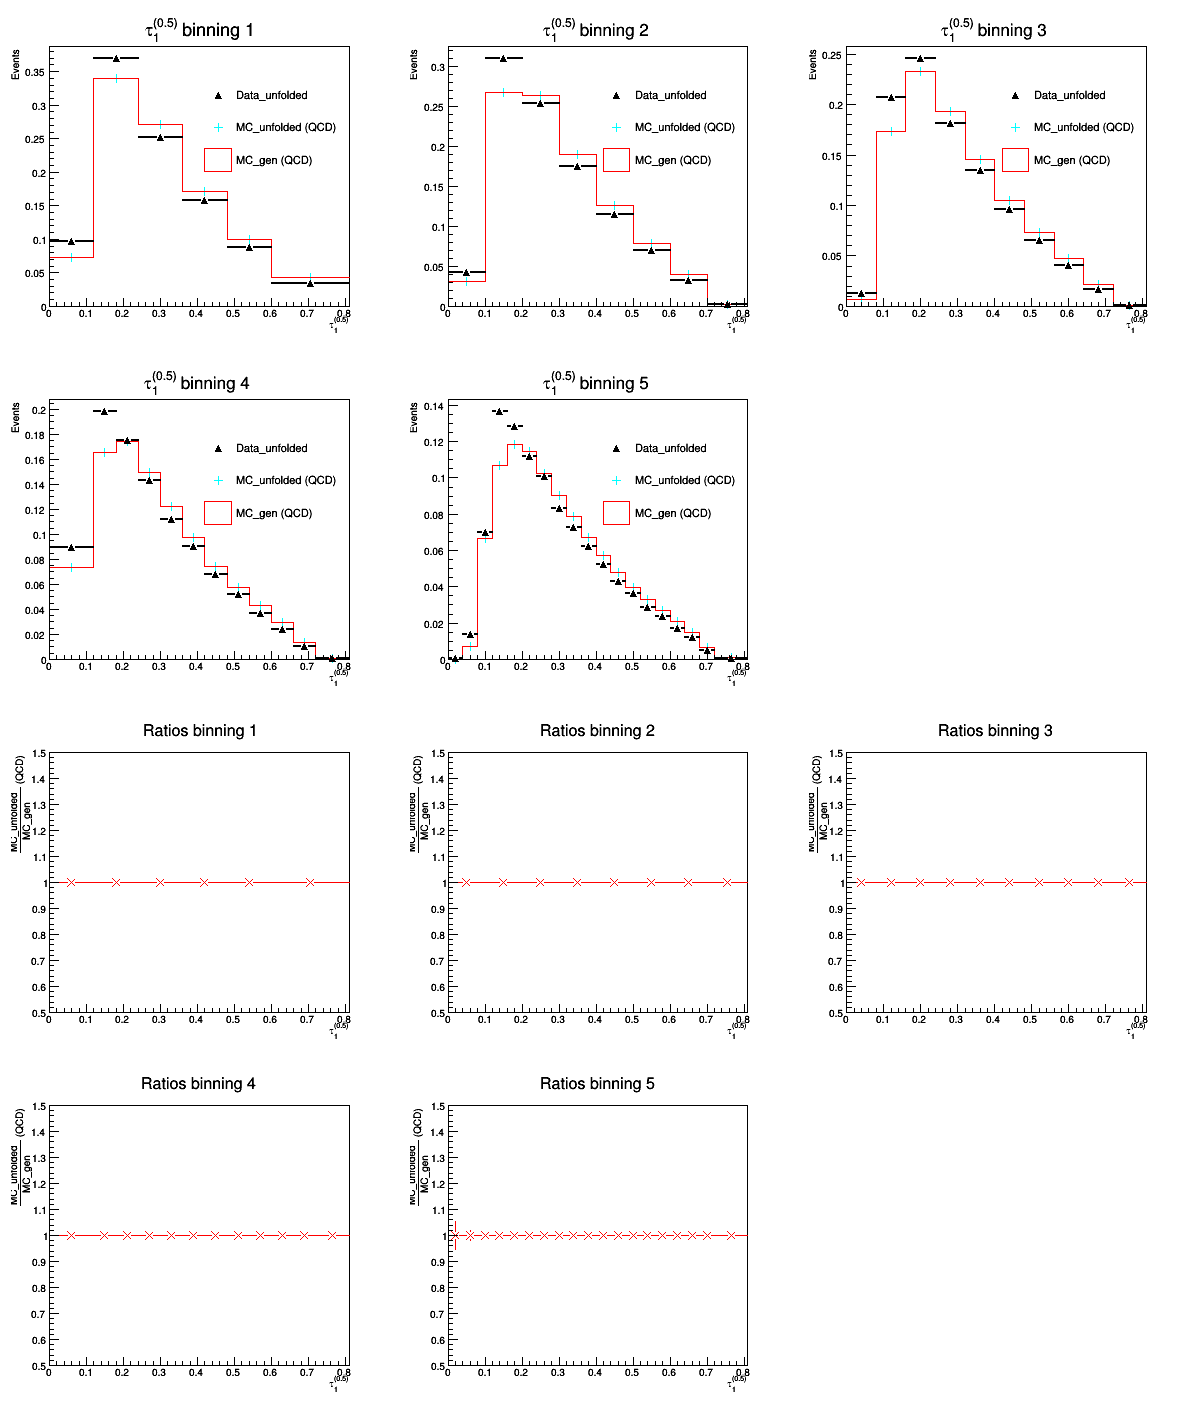

In [29]:
c=rt.TCanvas("","",0,0,1200,1440)
c.Divide(3,4)
for i in range(len(gen_bins)):
    c.cd(i+1)
    stack_unfoldings[i].Draw("nostack")
    stack_unfoldings[i].GetXaxis().SetTitle("#tau_{1}^{(0.5)}")
    stack_unfoldings[i].GetYaxis().SetTitle("Events")
    leg_unfoldings[i].Draw("Same")
for i in range(6,6+len(gen_bins)):
    c.cd(i+1)
    ratio_unfoldings[i-6].Draw()
c.Draw()

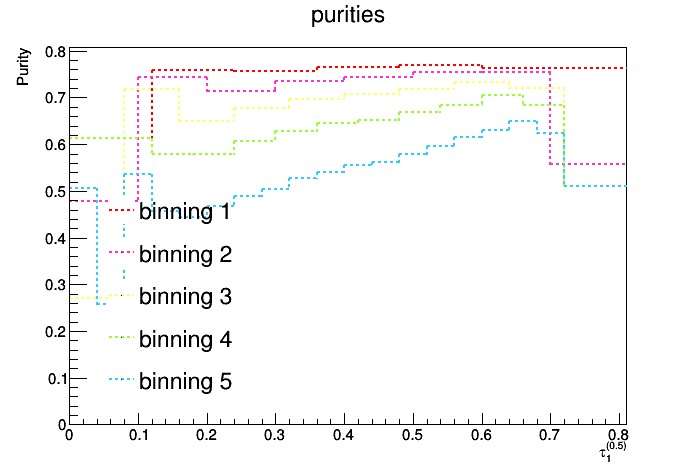

In [30]:
c=rt.TCanvas()
stack_purities.Draw("nostack")
stack_purities.GetXaxis().SetTitle("#tau_{1}^{(0.5)}")
stack_purities.GetYaxis().SetTitle("Purity")
stack_purities.Draw("nostack")
leg_purities.Draw("same")
c.Draw()

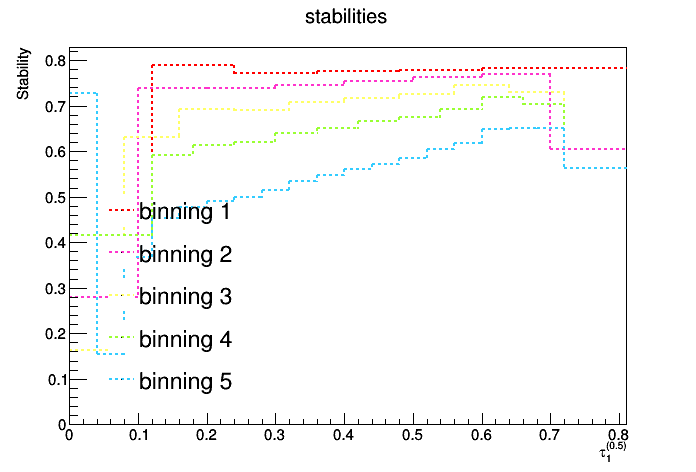

In [32]:
c=rt.TCanvas()
stack_stabilities.Draw("nostack")
stack_stabilities.GetXaxis().SetTitle("#tau_{1}^{(0.5)}")
stack_stabilities.GetYaxis().SetTitle("Stability")
stack_stabilities.Draw("nostack")
leg_stabilities.Draw("Same")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/Response_tau_0p5_0_dijetSel.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: 1
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/PurityStability_tau_0p5_0_dijetSel.png has been created


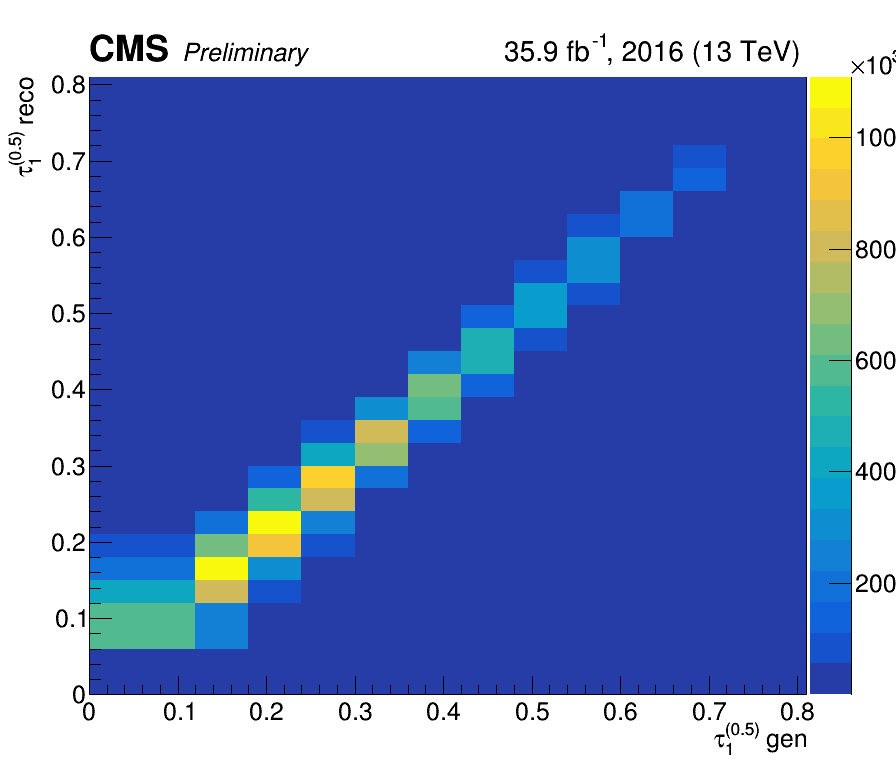

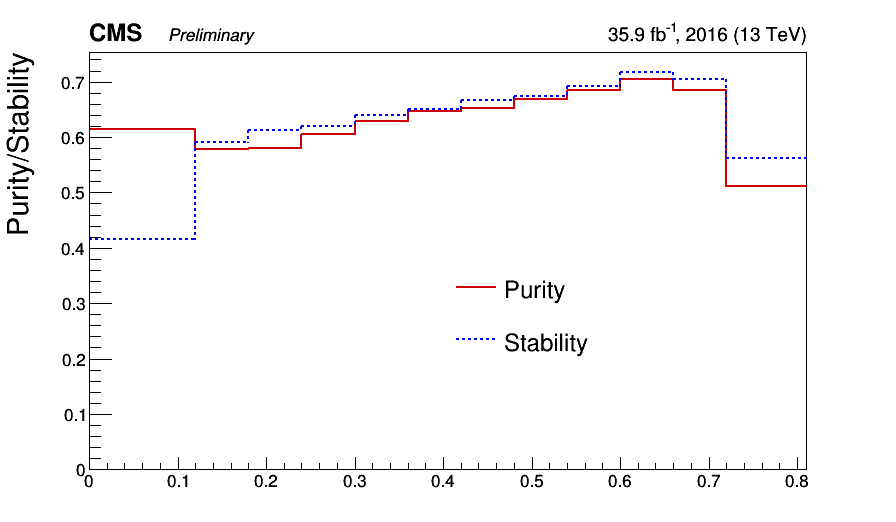

In [81]:
i=3
CMS_lumi.lumiTextSize=0.4
CMS_lumi.cmsTextSize=0.5
CMS_lumi.extraOverCmsTextSize=0.7
CMS_lumi.extraText="Preliminary"
CMS_lumi.lumi_13TeV=str(round((lumi/1000.),2))+" fb^{-1}, 2016 (13 TeV)"
CMS_lumi.relPosX=0.13
c1=rt.TCanvas("","",0,0,900,800)
responses[i].SetTitle("")
responses[i].Draw("Colz")
CMS_lumi.CMS_lumi(c1,4,0)
c1.Draw()
c1.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/Response_'+gen.split("t_")[1]+'.png')

CMS_lumi.relPosX=0.11
c2=rt.TCanvas("1","1",0,0,900,550)
ps=rt.THStack("","")
hist_purities[i].SetLineStyle(1)
hist_purities[i].SetLineColor(rt.kRed+1)
hist_stabilities[i].SetLineStyle(2)
hist_stabilities[i].SetLineColor(rt.kBlue)
ps.Add(hist_purities[i],"hist")
ps.Add(hist_stabilities[i],"hist")
ps.Draw("nostack")
#ps.GetXaxis().SetTitle("#tau_{1}^{(0.5)}")
ps.GetYaxis().SetTitle("Purity/Stability")
ps.GetYaxis().SetTitleSize(0.06)
ps.GetYaxis().SetTitleOffset(0.8)
leg=rt.TLegend(0.5,0.3,0.75,0.5)
leg.AddEntry(hist_purities[i],"Purity","l")
leg.AddEntry(hist_stabilities[i],"Stability","l")
leg.SetLineColor(0)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetTextSize(0.05)
leg.Draw("Same")
CMS_lumi.CMS_lumi(c2,4,0)
c2.Draw()
c2.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/PurityStability_'+gen.split("t_")[1]+'.png')

# $\tau_{1}^{(1)}$

In [7]:
reco='recoJet_tau_1_0_nom_dijetSel'
gen='genJet_tau_1_0_dijetSel'
response='respJet_tau_1_0_nom_dijetSel'

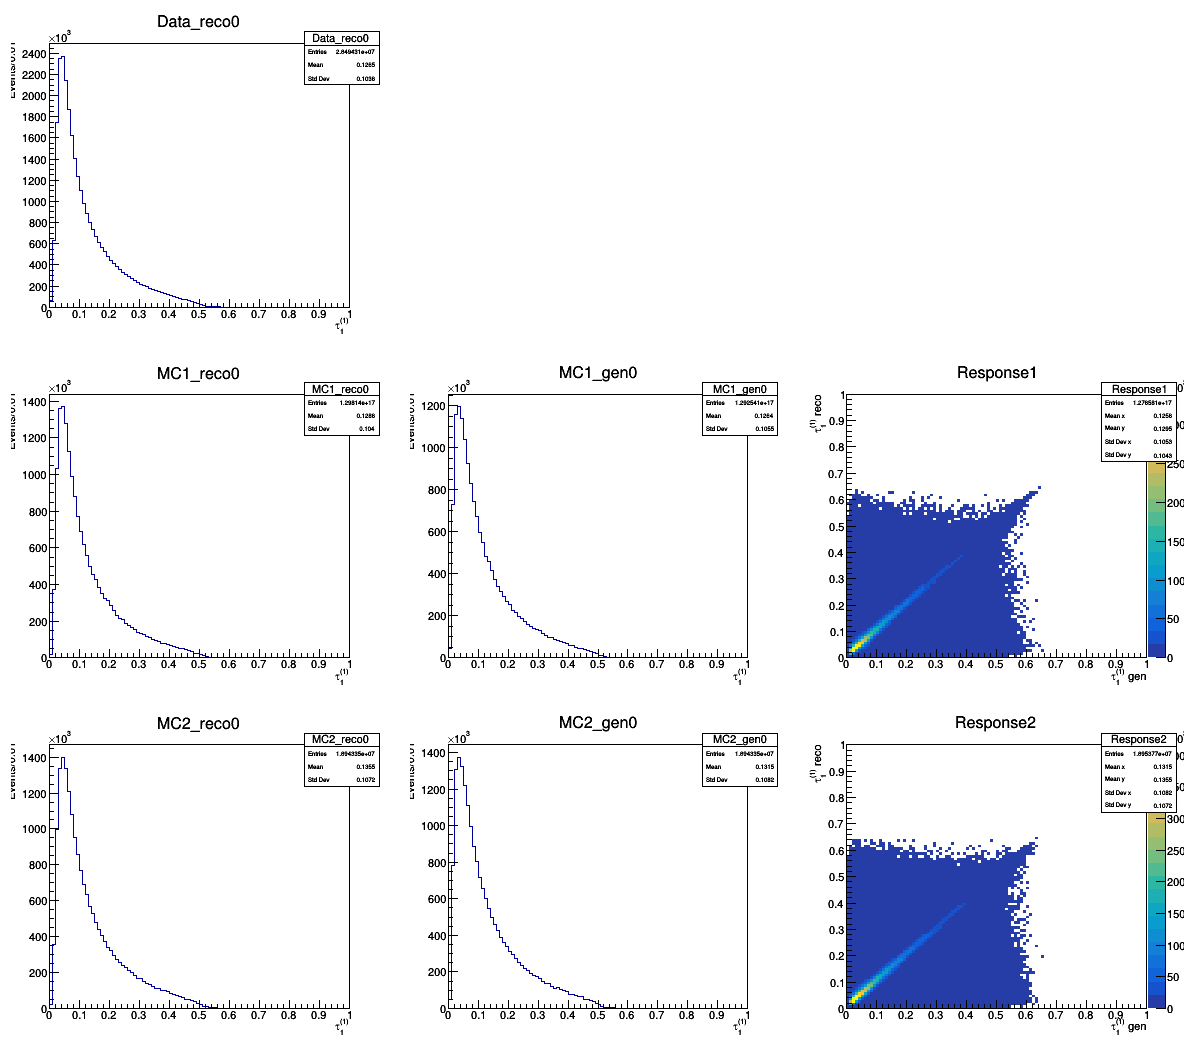

In [8]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{1}^{(1)};Events/0.01",100,0,1)
MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{1}^{(1)};Events/0.01",100,0,1)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{1}^{(1)};Events/0.01",100,0,1)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{1}^{(1)};Events/0.01",100,0,1)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{1}^{(1)};Events/0.01",100,0,1)
Response1_0=rt.TH2D("Response1","Response1;#tau_{1}^{(1)} gen;#tau_{1}^{(1)} reco",100,0,1,100,0,1)
Response2_0=rt.TH2D("Response2","Response2;#tau_{1}^{(1)} gen;#tau_{1}^{(1)} reco",100,0,1,100,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    hist=rt.TH1D("",";;",20,0,1)
    Data_reco0.Add(t.Get(reco))
    f_Data[i].Close()

f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
MC1_reco0.Add(t.Get(reco),Scale[i])
MC1_gen0.Add(t.Get(gen),Scale[i])
Response1_0.Add(t.Get(response),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    #MC2_reco0.Add(t.Get(reco),Scale[i])
    #MC2_gen0.Add(t.Get(gen),Scale[i])
    MC2_reco0.Add(t.Get(response).ProjectionY(),Scale[i])
    MC2_gen0.Add(t.Get(response).ProjectionX(),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,1080)
c0.Divide(3,3)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(4)
MC1_reco0.Draw("hist")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.cd(6)
Response1_0.Draw("Colz")
c0.cd(7)
MC2_reco0.Draw("hist")
c0.cd(8)
MC2_gen0.Draw("hist")
c0.cd(9)
Response2_0.Draw("Colz")
c0.Draw()

In [9]:
for i in range(MC2_reco0.GetNbinsX()):
    print Response2_0.ProjectionX().GetBinCenter(i+1),Response2_0.ProjectionX().GetBinContent(i+1),Response2_0.ProjectionY().GetBinContent(i+1)

0.005 48514.4287617 20592.1410803
0.015 783758.721668 358406.924584
0.025 1306513.30949 995345.101871
0.035 1373511.77258 1338163.12124
0.045 1325383.69986 1398676.72576
0.055 1222151.44929 1336211.08196
0.065 1110822.02694 1208918.6037
0.075 996442.54173 1079417.27966
0.085 888265.209329 952445.964608
0.095 805174.248862 855967.653158
0.105 717582.225347 768189.326397
0.115 656971.386578 689680.017332
0.125 603160.925451 632527.482245
0.135 547992.98931 570662.365629
0.145 499670.491034 527722.279992
0.155 458549.863509 478379.231653
0.165 428111.560538 438976.093791
0.175 391024.575028 408267.146314
0.185 361975.482372 374513.444192
0.195 338799.732646 342498.984509
0.205 311432.422449 322501.049269
0.215 296082.249003 297811.55175
0.225 273043.426279 275728.219166
0.235 249131.450639 258542.785788
0.245 232907.022107 239150.380582
0.255 219056.031368 226873.063002
0.265 205744.766647 210131.280741
0.275 192120.943852 197804.889191
0.285 180519.478243 182071.890407
0.295 172542.52249

In [10]:
gen_bins=[]
reco_bins=[]

gen_bins1=np.array([x for x in np.linspace(num=6,start=0.,stop=0.5)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.66])))
reco_bins1=np.array([x for x in np.linspace(num=11,start=0.,stop=0.5)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.58,0.66])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=7,start=0.,stop=0.48)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.66])))
reco_bins1=np.array([x for x in np.linspace(num=13,start=0.,stop=0.48)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.57,0.66])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=9,start=0.,stop=0.48)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.66])))
reco_bins1=np.array([x for x in np.linspace(num=17,start=0.,stop=0.48)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.57,0.66])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=13,start=0.,stop=0.48)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.66])))
reco_bins1=np.array([x for x in np.linspace(num=25,start=0.,stop=0.48)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.57,0.66])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)
print(",".join(str(i) for i in gen_bins1))
print(",".join(str(i) for i in reco_bins1))

gen_bins1=np.array([x for x in np.linspace(num=25,start=0.,stop=0.48)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.66])))
reco_bins1=np.array([x for x in np.linspace(num=49,start=0.,stop=0.48)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.57,0.66])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)
#print(",".join(str(i) for i in gen_bins1))
#print(",".join(str(i) for i in reco_bins1))

Colors=[rt.kRed,rt.kPink+9,rt.kYellow-7,rt.kSpring-9,rt.kAzure+8,rt.kBlue]

[0.   0.1  0.2  0.3  0.4  0.5  0.66] 6
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.58 0.66] 12
[0.   0.08 0.16 0.24 0.32 0.4  0.48 0.66] 7
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.57
 0.66] 14
[0.   0.06 0.12 0.18 0.24 0.3  0.36 0.42 0.48 0.66] 9
[0.   0.03 0.06 0.09 0.12 0.15 0.18 0.21 0.24 0.27 0.3  0.33 0.36 0.39
 0.42 0.45 0.48 0.57 0.66] 18
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.66] 13
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.57 0.66] 26
0.0,0.04,0.08,0.12,0.16,0.2,0.24,0.28,0.32,0.36,0.4,0.44,0.48,0.66
0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.3,0.32,0.34,0.36,0.38,0.4,0.42,0.44,0.46,0.48,0.57,0.66
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.66] 25
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0

In [16]:
hist_purities=[]
hist_stabilities=[]
stack_unfoldings=[]
ratio_unfoldings=[]

responses=[]

c=rt.TCanvas()
stack_purities=rt.THStack("purities","purities")
stack_stabilities=rt.THStack("stabilities","stabilities")

leg_unfoldings=[]
leg_purities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_purities.SetLineColor(0)
leg_purities.SetBorderSize(0)
leg_purities.SetFillStyle(0)
leg_stabilities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_stabilities.SetLineColor(0)
leg_stabilities.SetBorderSize(0)
leg_stabilities.SetFillStyle(0)

for i in range(len(gen_bins)):
    gen_bin=gen_bins[i]
    reco_bin=reco_bins[i]
    print "for binning %d"%(i+1)
    print gen_bin
    
    Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{1}^{(1)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_reco=rt.TH1D("MC_reco (QCD)","MC2_reco (QCD);#tau_{1}^{(1)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_gen=rt.TH1D("MC_gen (QCD)","MC_gen (QCD);#tau_{1}^{(1)};Events",gen_bin.shape[0]-1,gen_bin)
    Response2=rt.TH2D("Response Matrix (QCD)","Response Matrix (QCD);#tau_{1}^{(1)} gen;#tau_{1}^{(1)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    
    Fill1D(Data_reco0,Data_reco,reco_bin)
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    Fill2D(Response2_0,Response2,gen_bin,reco_bin)

    Response2.SetTitle("Response Matrix #tau_{1}^{(1)} binning %d"%(i+1))
    Response2.SetStats(0)
    responses.append(Response2)
    
    purity,stability=PurityStability(Response2_0,gen_bin)
    
    purity.SetTitle("purity %d"%(i+1))
    stability.SetTitle("stability %d"%(i+1))
    purity.SetLineColor(Colors[i])
    stability.SetLineColor(Colors[i])
    hist_purities.append(purity)
    hist_stabilities.append(stability)
    stack_purities.Add(purity)
    stack_stabilities.Add(stability)
    leg_purities.AddEntry(purity,"binning %d"%(i+1))
    leg_stabilities.AddEntry(stability,"binning %d"%(i+1))
    
    Data_reco.Scale(1.0/Data_reco.Integral())
    MC2_reco.Scale(1.0/MC2_reco.Integral())
    MC2_gen.Scale(1.0/MC2_gen.Integral())
    
    hs,ratio,leg=DoUnfolding(Response2,Data_reco,MC2_reco,MC2_gen,"#tau_{1}^{(1)}","Pythia_ptbinned",gen_bin)
    
    hs.SetTitle("#tau_{1}^{(1)} binning %d"%(i+1))
    #ratio.SetTitle("Ratios binning %d"%(i+1))
    stack_unfoldings.append(hs)
    ratio_unfoldings.append(ratio)
    leg_unfoldings.append(leg)

for binning 1
[0.   0.1  0.2  0.3  0.4  0.5  0.66]
for binning 2
[0.   0.08 0.16 0.24 0.32 0.4  0.48 0.66]
for binning 3
[0.   0.06 0.12 0.18 0.24 0.3  0.36 0.42 0.48 0.66]
for binning 4
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.66]
for binning 5
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.66]


Warning in <TROOT::Append>: Replacing existing TH1: Data_reco (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_reco (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_gen (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Response Matrix (QCD) (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Purity (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: Stability (Potential memory leak).
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 12 input bins and 6 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{1}^{(1)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #7 (xaxis:#tau_{1}^{(1)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densi

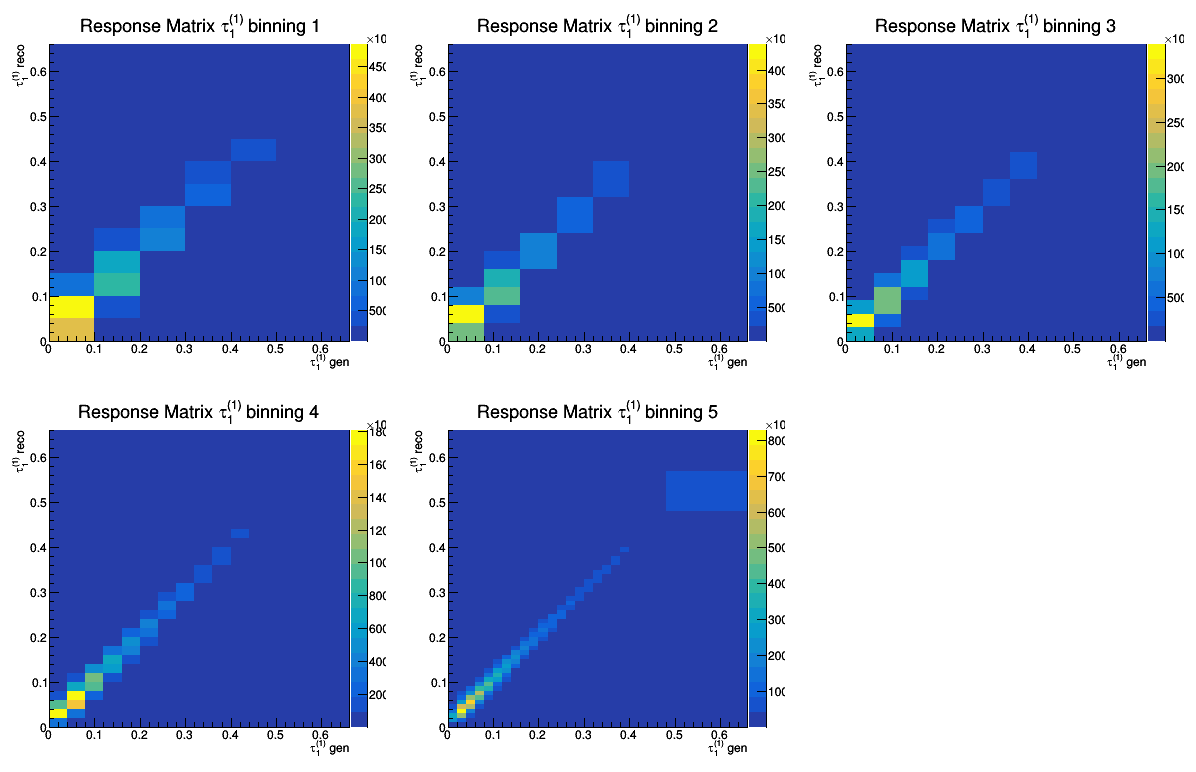

In [12]:
c=rt.TCanvas("","",0,0,1200,800)
c.Divide(3,2)
for i in range(len(gen_bins)):
    c.cd(i+1)
    responses[i].Draw("Colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


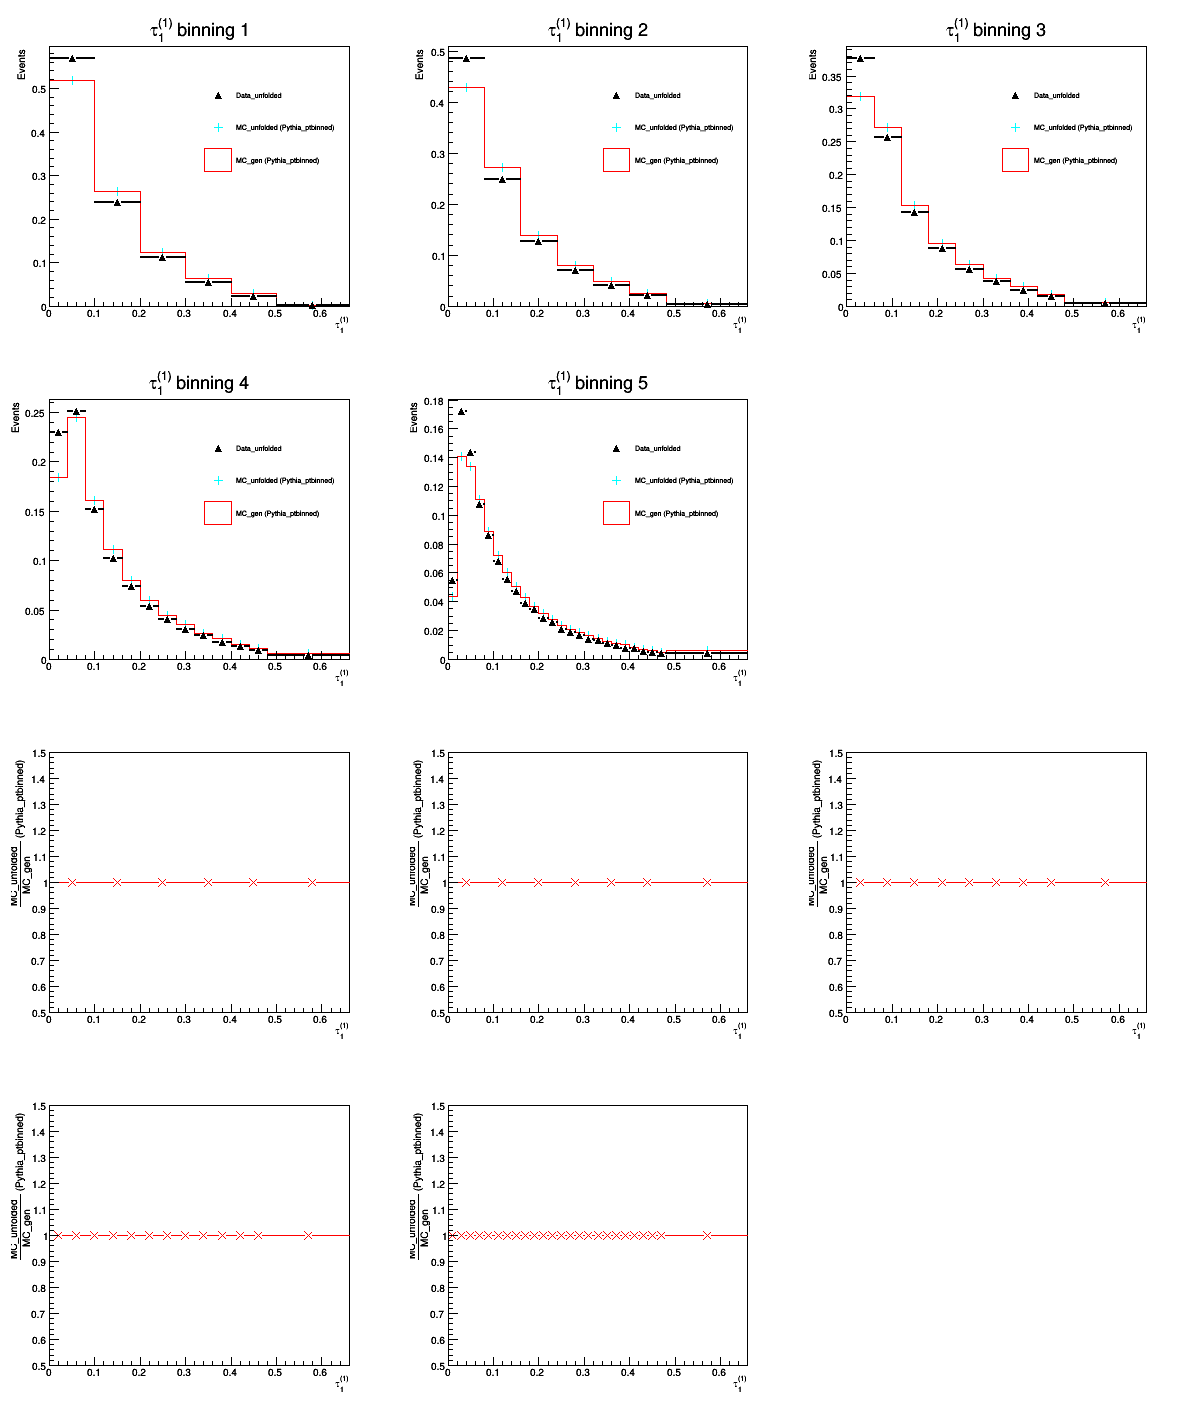

In [18]:
c=rt.TCanvas("","",0,0,1200,1440)
c.Divide(3,4)
for i in range(len(gen_bins)):
    c.cd(i+1)
    stack_unfoldings[i].Draw("nostack")
    stack_unfoldings[i].GetXaxis().SetTitle("#tau_{1}^{(1)}")
    stack_unfoldings[i].GetYaxis().SetTitle("Events")
    leg_unfoldings[i].Draw("Same")
for i in range(6,len(gen_bins)+6):
    c.cd(i+1)
    ratio_unfoldings[i-6].SetTitle("")
    ratio_unfoldings[i-6].Draw()
c.Draw()

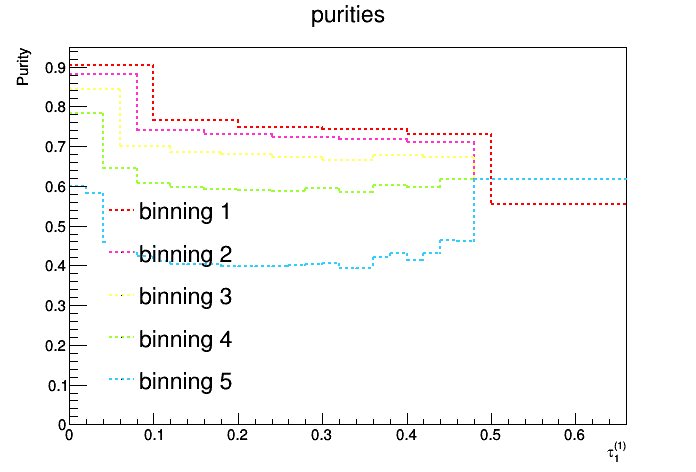

In [91]:
c=rt.TCanvas()
stack_purities.Draw("nostack")
stack_purities.GetXaxis().SetTitle("#tau_{1}^{(1)}")
stack_purities.GetYaxis().SetTitle("Purity")
stack_purities.Draw("nostack")
leg_purities.Draw("same")
c.Draw()

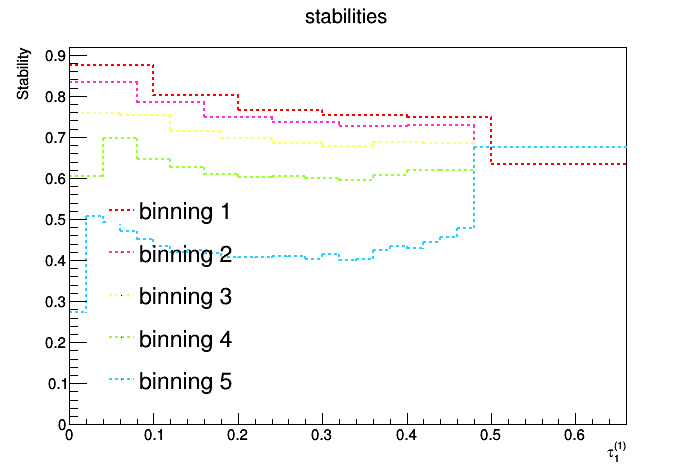

In [92]:
c=rt.TCanvas()
stack_stabilities.Draw("nostack")
stack_stabilities.GetXaxis().SetTitle("#tau_{1}^{(1)}")
stack_stabilities.GetYaxis().SetTitle("Stability")
stack_stabilities.Draw("nostack")
leg_stabilities.Draw("Same")
c.Draw()

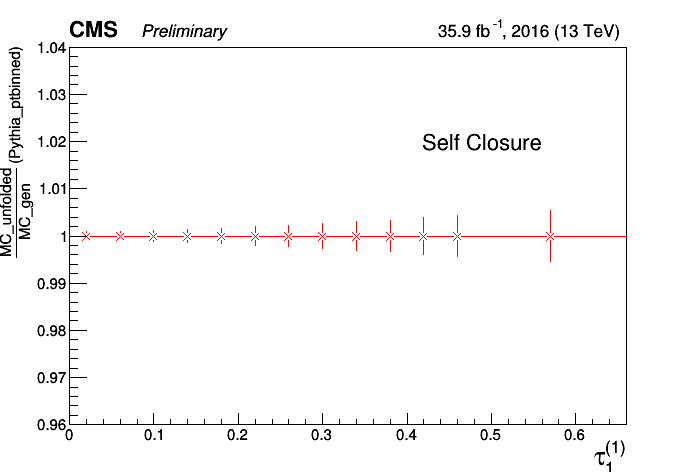

In [33]:
i=3
CMS_lumi.lumiTextSize=0.4
CMS_lumi.cmsTextSize=0.5
CMS_lumi.extraOverCmsTextSize=0.8
CMS_lumi.extraText="Preliminary"
CMS_lumi.lumi_13TeV=str(round((lumi/1000.),2))+" fb^{-1}, 2016 (13 TeV)"
CMS_lumi.relPosX=0.13
c=rt.TCanvas()
#ratio_unfoldings[i].SetTitle("Self Closure")
ratio_unfoldings[i].GetYaxis().SetRangeUser(0.96,1.04)
ratio_unfoldings[i].GetXaxis().SetTitleSize(0.06)
ratio_unfoldings[i].GetXaxis().SetTitleOffset(0.7)
ratio_unfoldings[i].Draw()
CMS_lumi.CMS_lumi(c,4,0)
leg=rt.TLegend(.6,.6,.9,.8,'Self Closure')
leg.SetLineColor(0)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetTextSize(0.05)
leg.Draw("Same")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/Response_tau_1_0_dijetSel.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: 1
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/PurityStability_tau_1_0_dijetSel.png has been created


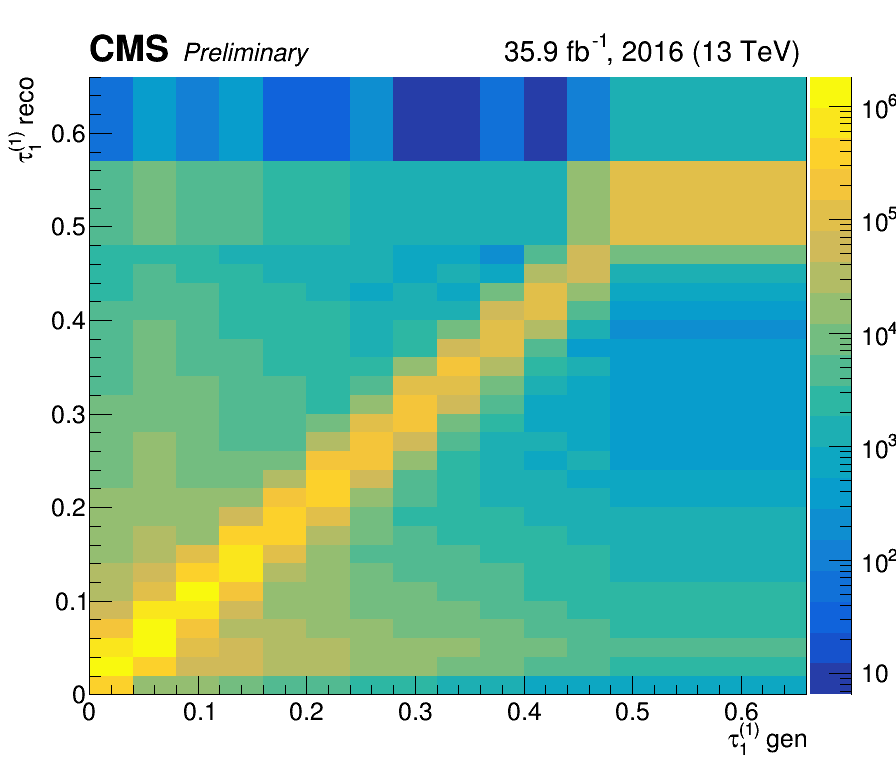

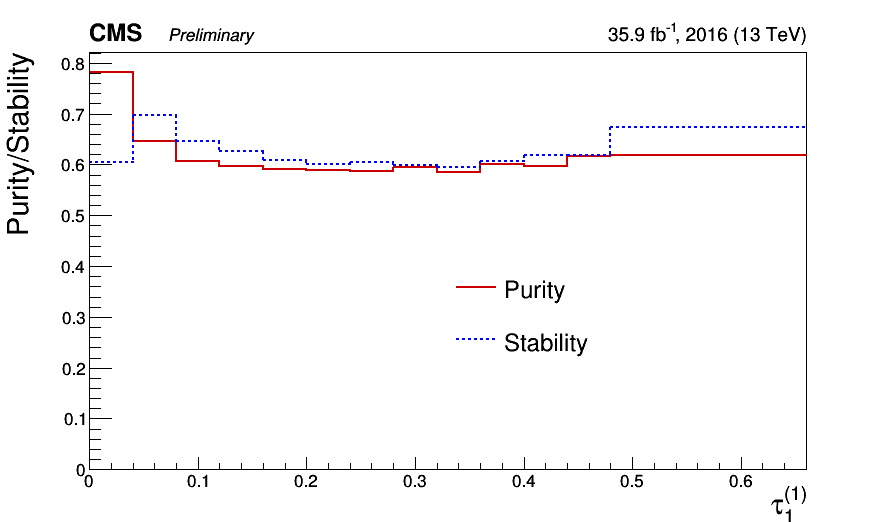

In [41]:
i=3
%jsroot off
CMS_lumi.lumiTextSize=0.4
CMS_lumi.cmsTextSize=0.5
CMS_lumi.extraOverCmsTextSize=0.7
CMS_lumi.extraText="Preliminary"
CMS_lumi.lumi_13TeV=str(round((lumi/1000.),2))+" fb^{-1}, 2016 (13 TeV)"
CMS_lumi.relPosX=0.13
c1=rt.TCanvas("","",0,0,900,800)
c1.SetLogz()
responses[i].SetTitle("")
responses[i].Draw("Colz")
CMS_lumi.CMS_lumi(c1,4,0)
c1.Draw()
c1.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/Response_'+gen.split("t_")[1]+'.png')

CMS_lumi.relPosX=0.11
c2=rt.TCanvas("1","1",0,0,900,550)
ps=rt.THStack("","")
hist_purities[i].SetLineStyle(1)
hist_purities[i].SetLineColor(rt.kRed+1)
hist_stabilities[i].SetLineStyle(2)
hist_stabilities[i].SetLineColor(rt.kBlue)
ps.Add(hist_purities[i],"hist")
ps.Add(hist_stabilities[i],"hist")
ps.Draw("nostack")
#ps.GetXaxis().SetTitle("#tau_{1}^{(0.5)}")
ps.GetYaxis().SetTitle("Purity/Stability")
ps.GetYaxis().SetTitleSize(0.06)
ps.GetYaxis().SetTitleOffset(0.8)
ps.GetXaxis().SetTitle("#tau_{1}^{(1)}")
ps.GetXaxis().SetTitleSize(0.06)
ps.GetXaxis().SetTitleOffset(0.7)
leg=rt.TLegend(0.5,0.3,0.75,0.5)
leg.AddEntry(hist_purities[i],"Purity","l")
leg.AddEntry(hist_stabilities[i],"Stability","l")
leg.SetLineColor(0)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetTextSize(0.05)
leg.Draw("Same")
CMS_lumi.CMS_lumi(c2,4,0)
c2.Draw()
c2.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/PurityStability_'+gen.split("t_")[1]+'.png')

# $\tau_1^{(2)}$

In [7]:
reco='recoJet_tau_2_0_nom_dijetSel'
gen='genJet_tau_2_0_dijetSel'
response='respJet_tau_2_0_nom_dijetSel'

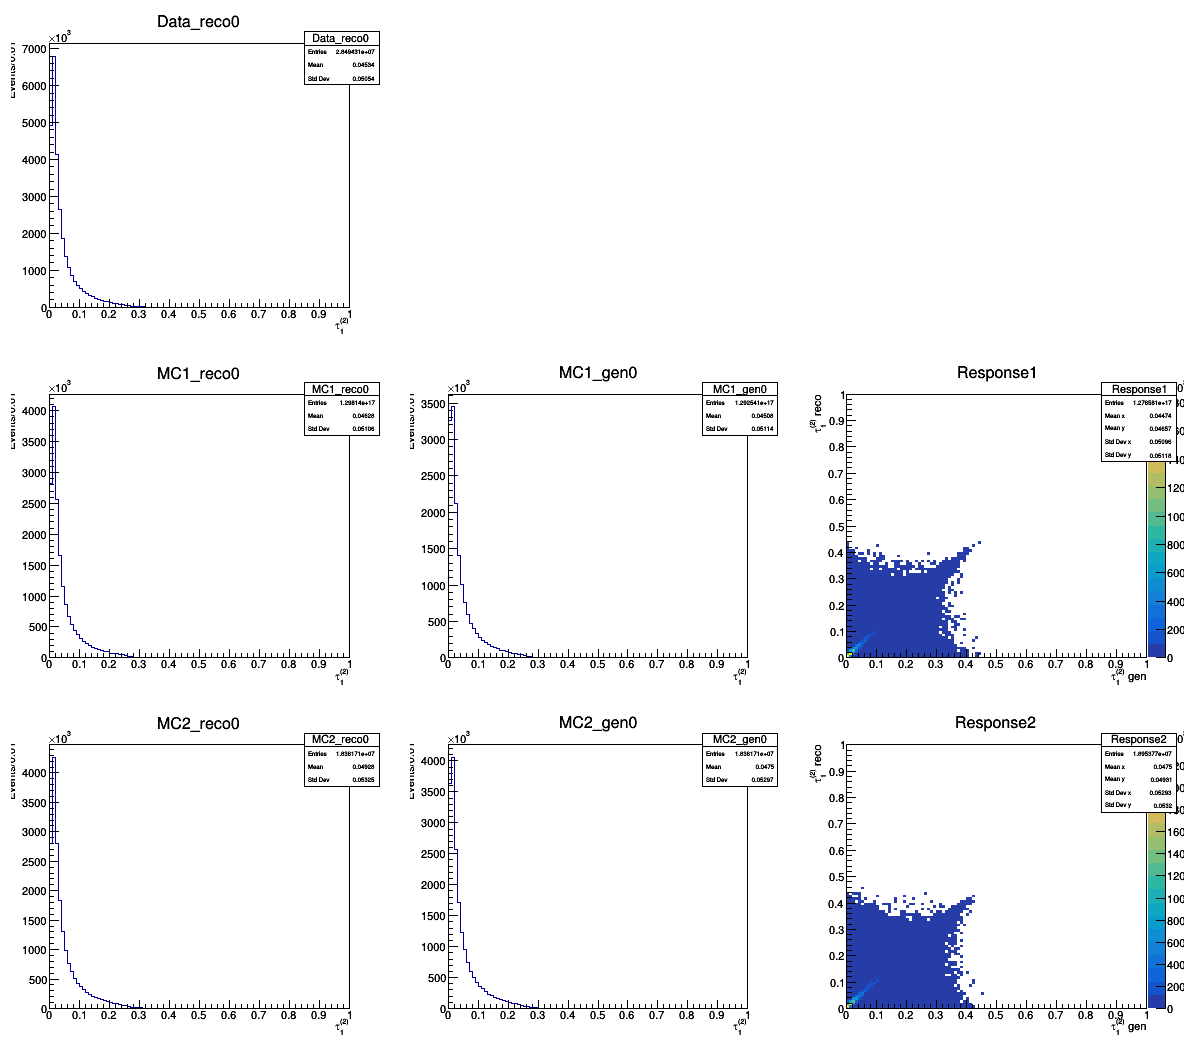

In [8]:
Data_reco0=rt.TH1D("Data_reco0","Data_reco0;#tau_{1}^{(2)};Events/0.01",100,0,1)
MC1_reco0=rt.TH1D("MC1_reco0","MC1_reco0;#tau_{1}^{(2)};Events/0.01",100,0,1)
MC1_gen0=rt.TH1D("MC1_gen0","MC1_gen0;#tau_{1}^{(2)};Events/0.01",100,0,1)
MC2_reco0=rt.TH1D("MC2_reco0","MC2_reco0;#tau_{1}^{(2)};Events/0.01",100,0,1)
MC2_gen0=rt.TH1D("MC2_gen0","MC2_gen0;#tau_{1}^{(2)};Events/0.01",100,0,1)
Response1_0=rt.TH2D("Response1","Response1;#tau_{1}^{(2)} gen;#tau_{1}^{(2)} reco",100,0,1,100,0,1)
Response2_0=rt.TH2D("Response2","Response2;#tau_{1}^{(2)} gen;#tau_{1}^{(2)} reco",100,0,1,100,0,1)

f_Data=np.zeros((len(fData),),dtype=rt.TFile)
for i in range(len(fData)):
    f_Data[i]=rt.TFile.Open(fData[i],'read')
    t=f_Data[i].Get('jetObservables')
    hist=rt.TH1D("",";;",20,0,1)
    Data_reco0.Add(t.Get(reco))
    f_Data[i].Close()

f_MC=np.zeros((len(fMC),),dtype=rt.TFile)
i=0
f_MC[i]=rt.TFile.Open(fMC[i],'read')
t=f_MC[i].Get('jetObservables')
MC1_reco0.Add(t.Get(reco),Scale[i])
MC1_gen0.Add(t.Get(gen),Scale[i])
Response1_0.Add(t.Get(response),Scale[i])
f_MC[i].Close()

for i in range(1,len(fMC)):
    f_MC[i]=rt.TFile.Open(fMC[i],'read')
    t=f_MC[i].Get('jetObservables')
    #MC2_reco0.Add(t.Get(reco),Scale[i])
    #MC2_gen0.Add(t.Get(gen),Scale[i])
    MC2_reco0.Add(t.Get(response).ProjectionY(),Scale[i])
    MC2_gen0.Add(t.Get(response).ProjectionX(),Scale[i])
    Response2_0.Add(t.Get(response),Scale[i])
    f_MC[i].Close()

c0=rt.TCanvas("c0","c0",0,0,1200,1080)
c0.Divide(3,3)
c0.cd(1)
Data_reco0.Draw("hist")
c0.cd(4)
MC1_reco0.Draw("hist")
c0.cd(5)
MC1_gen0.Draw("hist")
c0.cd(6)
Response1_0.Draw("Colz")
c0.cd(7)
MC2_reco0.Draw("hist")
c0.cd(8)
MC2_gen0.Draw("hist")
c0.cd(9)
Response2_0.Draw("Colz")
c0.Draw()

In [9]:
for i in range(MC2_reco0.GetNbinsX()):
    print Response2_0.ProjectionX().GetBinCenter(i+1),Response2_0.ProjectionX().GetBinContent(i+1),Response2_0.ProjectionY().GetBinContent(i+1)

0.005 3634090.10793 2800832.97894
0.015 4057838.1438 4264428.41058
0.025 2563108.44959 2795433.26747
0.035 1715685.4676 1841925.12032
0.045 1222247.94638 1313514.11673
0.055 945618.287462 984782.311447
0.065 742014.448544 765131.585203
0.075 601946.896865 626469.678154
0.085 498084.306837 516308.487506
0.095 420471.619801 427457.223318
0.105 362455.934411 368146.847759
0.115 317295.125475 320419.413147
0.125 271452.860046 279151.127082
0.135 228874.784977 236593.275342
0.145 203463.503748 202456.618123
0.155 184668.084531 181667.640446
0.165 161276.167013 166279.119398
0.175 144060.353616 151424.659648
0.185 133087.515064 133452.676797
0.195 111599.066562 111990.869502
0.205 99007.1163739 103569.53672
0.215 85412.0803322 86945.5017103
0.225 74435.3374443 79950.2106509
0.235 64167.3997471 66536.0722403
0.245 54377.1842755 53354.1968827
0.255 39845.8819736 45273.6573702
0.265 29603.6985964 33435.6832424
0.275 21514.1331802 22267.3458301
0.285 15490.8159651 15105.4944928
0.295 10442.82625

In [10]:
gen_bins=[]
reco_bins=[]

gen_bins1=np.array([x for x in np.linspace(num=4,start=0.,stop=0.24)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.46])))
reco_bins1=np.array([x for x in np.linspace(num=7,start=0.,stop=0.24)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.35,0.46])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=6,start=0.,stop=0.3)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.46])))
reco_bins1=np.array([x for x in np.linspace(num=11,start=0.,stop=0.3)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.37,0.46])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)

gen_bins1=np.array([x for x in np.linspace(num=8,start=0.,stop=0.28)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.46])))
reco_bins1=np.array([x for x in np.linspace(num=15,start=0.,stop=0.28)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.36,0.46])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)
print(",".join(str(i) for i in gen_bins1))
print(",".join(str(i) for i in reco_bins1))

gen_bins1=np.array([x for x in np.linspace(num=15,start=0.,stop=0.28)])
gen_bins1=np.concatenate((gen_bins1,np.array([0.46])))
reco_bins1=np.array([x for x in np.linspace(num=29,start=0.,stop=0.28)])
reco_bins1=np.concatenate((reco_bins1,np.array([0.36,0.46])))
print gen_bins1,gen_bins1.shape[0]-1
print reco_bins1,reco_bins1.shape[0]-1
gen_bins.append(gen_bins1)
reco_bins.append(reco_bins1)


Colors=[rt.kRed,rt.kPink+9,rt.kYellow-7,rt.kSpring-9,rt.kAzure+8,rt.kBlue]

[0.   0.08 0.16 0.24 0.46] 4
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.35 0.46] 8
[0.   0.06 0.12 0.18 0.24 0.3  0.46] 6
[0.   0.03 0.06 0.09 0.12 0.15 0.18 0.21 0.24 0.27 0.3  0.37 0.46] 12
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.46] 8
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.36 0.46] 16
0.0,0.04,0.08,0.12,0.16,0.2,0.24,0.28,0.46
0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.36,0.46
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.46] 15
[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.36 0.46] 30


In [11]:
hist_purities=[]
hist_stabilities=[]
stack_unfoldings=[]
ratio_unfoldings=[]

responses=[]

c=rt.TCanvas()
stack_purities=rt.THStack("purities","purities")
stack_stabilities=rt.THStack("stabilities","stabilities")

leg_unfoldings=[]
leg_purities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_purities.SetLineColor(0)
leg_purities.SetBorderSize(0)
leg_purities.SetFillStyle(0)
leg_stabilities=rt.TLegend(0.15, 0.15, 0.35, 0.6)
leg_stabilities.SetLineColor(0)
leg_stabilities.SetBorderSize(0)
leg_stabilities.SetFillStyle(0)

for i in range(len(gen_bins)):
    gen_bin=gen_bins[i]
    reco_bin=reco_bins[i]
    print "for binning %d"%(i+1)
    print gen_bin
    
    Data_reco=rt.TH1D("Data_reco","Data_reco;#tau_{1}^{(2)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_reco=rt.TH1D("MC_reco (QCD)","MC2_reco (QCD);#tau_{1}^{(2)};Events",reco_bin.shape[0]-1,reco_bin)
    MC2_gen=rt.TH1D("MC_gen (QCD)","MC_gen (QCD);#tau_{1}^{(2)};Events",gen_bin.shape[0]-1,gen_bin)
    Response2=rt.TH2D("Response Matrix (QCD)","Response Matrix (QCD);#tau_{1}^{(2)} gen;#tau_{1}^{(2)} reco",gen_bin.shape[0]-1,gen_bin,reco_bin.shape[0]-1,reco_bin)
    
    Fill1D(Data_reco0,Data_reco,reco_bin)
    Fill1D(MC2_reco0,MC2_reco,reco_bin)
    Fill1D(MC2_gen0,MC2_gen,gen_bin)
    Fill2D(Response2_0,Response2,gen_bin,reco_bin)

    Response2.SetTitle("Response Matrix #tau_{1}^{(2)} binning %d"%(i+1))
    Response2.SetStats(0)
    responses.append(Response2)
    
    purity,stability=PurityStability(Response2_0,gen_bin)
    
    purity.SetTitle("purity %d"%(i+1))
    stability.SetTitle("stability %d"%(i+1))
    purity.SetLineColor(Colors[i])
    stability.SetLineColor(Colors[i])
    hist_purities.append(purity)
    hist_stabilities.append(stability)
    stack_purities.Add(purity)
    stack_stabilities.Add(stability)
    leg_purities.AddEntry(purity,"binning %d"%(i+1))
    leg_stabilities.AddEntry(stability,"binning %d"%(i+1))
    
    Data_reco.Scale(1.0/Data_reco.Integral())
    MC2_reco.Scale(1.0/MC2_reco.Integral())
    MC2_gen.Scale(1.0/MC2_gen.Integral())
    
    hs,ratio,leg=DoUnfolding(Response2,Data_reco,MC2_reco,MC2_gen,"#tau_{1}^{(2)}","Pythia_ptbinned",gen_bin)
    
    hs.SetTitle("#tau_{1}^{(2)} binning %d"%(i+1))
    ratio.SetTitle("Ratios binning %d"%(i+1))
    stack_unfoldings.append(hs)
    ratio_unfoldings.append(ratio)
    leg_unfoldings.append(leg)

for binning 1
[0.   0.08 0.16 0.24 0.46]
for binning 2
[0.   0.06 0.12 0.18 0.24 0.3  0.46]
for binning 3
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.46]
for binning 4
[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.46]


Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 8 input bins and 4 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{1}^{(2)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #5 (xaxis:#tau_{1}^{(2)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]
Info in <TUnfold::SetConstraint>: fConstraint=0
Info in <TUnfold::TUnfold>: underflow and overflow bin do not depend on the input data
Info in <TUnfold::TUnfold>: 8 input bins and 4 output bins
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #0 (xaxis:#tau_{1}^{(2)} gen[ufl])
Info in <TUnfoldDensity::TUnfold>: *NOT* unfolding bin #5 (xaxis:#tau_{1}^{(2)} gen[ofl])
Info in <TUnfoldDensity::RegularizeOneDistribution>: regularizing xaxis regMode=3 densityMode=1 axisSteering=*[UOB]
Warning in <TROOT::A

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


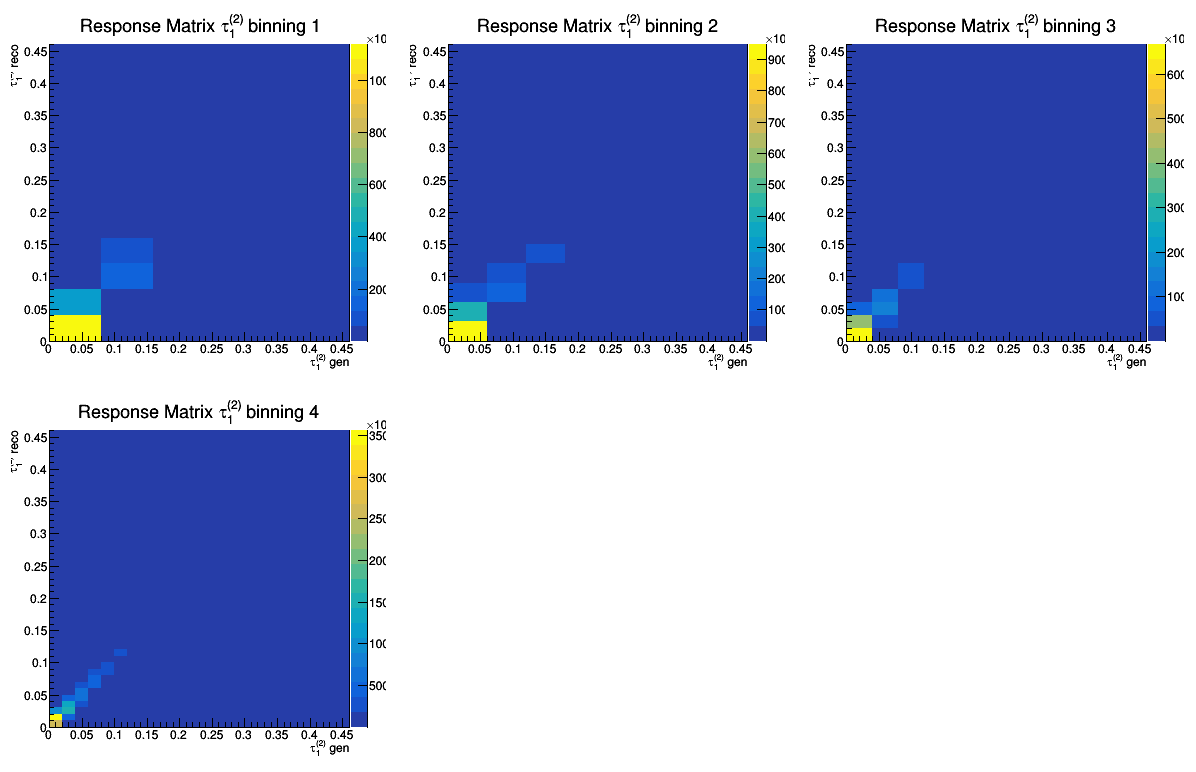

In [99]:
c=rt.TCanvas("","",0,0,1200,800)
c.Divide(3,2)
for i in range(len(gen_bins)):
    c.cd(i+1)
    responses[i].Draw("Colz")
c.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: 


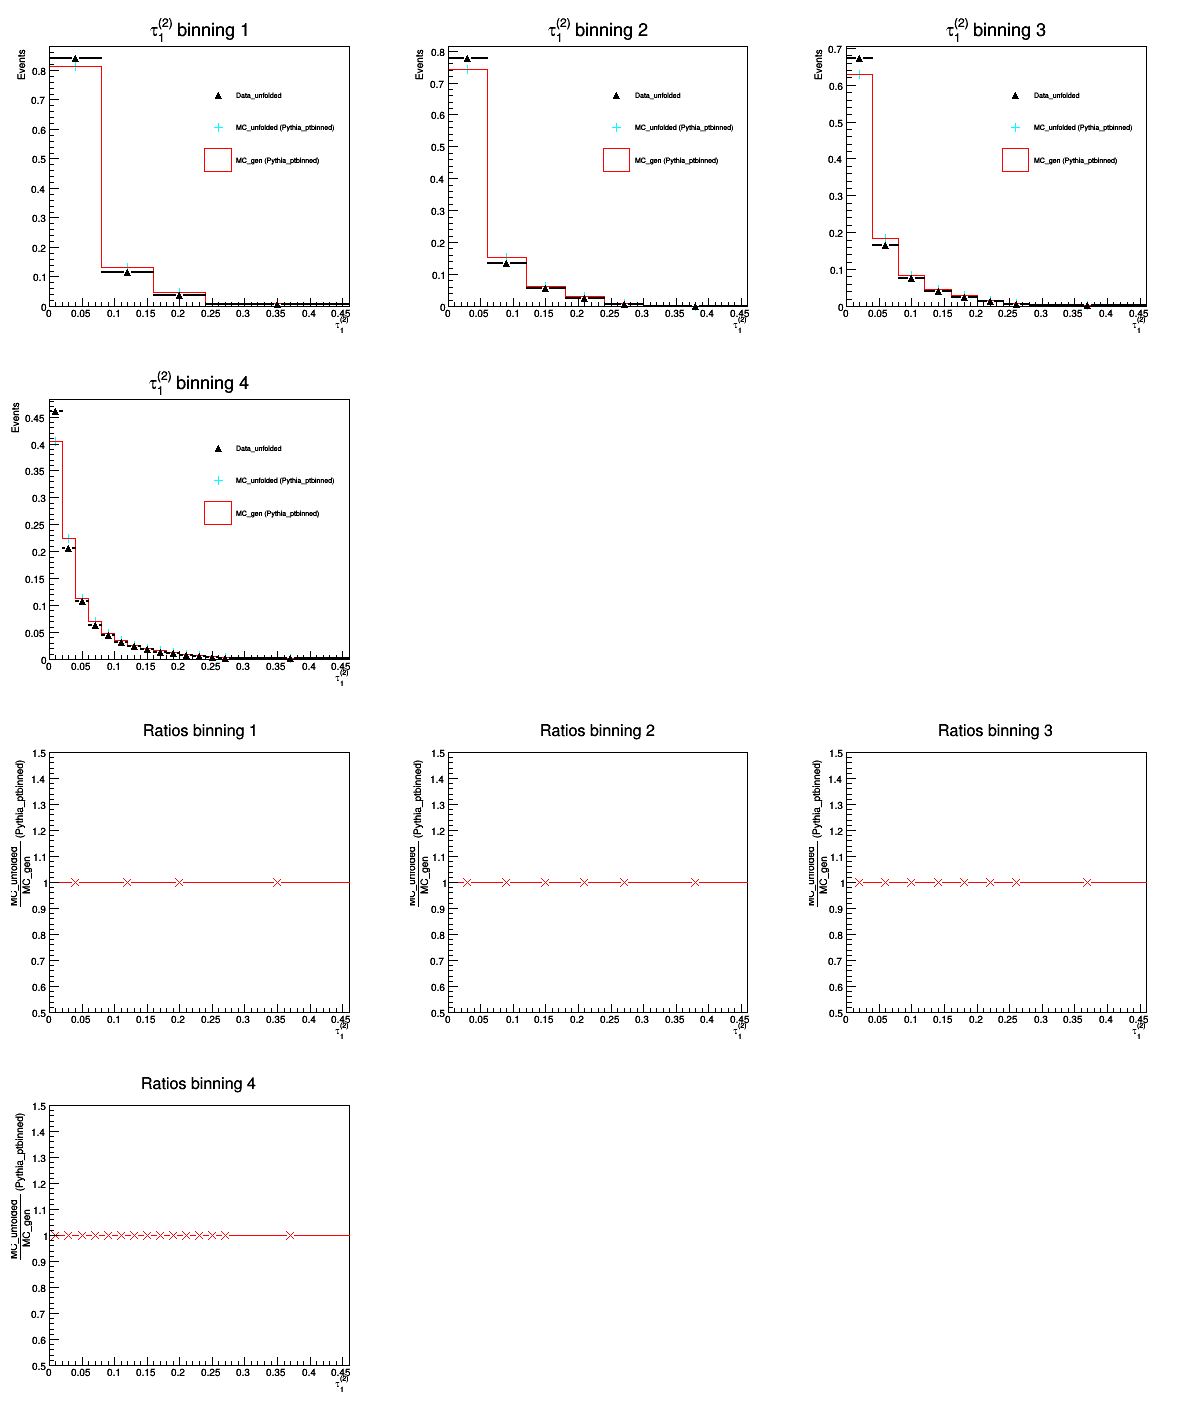

In [47]:
c=rt.TCanvas("","",0,0,1200,720*2)
c.Divide(3,4)
for i in range(len(gen_bins)):
    c.cd(i+1)
    stack_unfoldings[i].Draw("nostack")
    stack_unfoldings[i].GetXaxis().SetTitle("#tau_{1}^{(2)}")
    stack_unfoldings[i].GetYaxis().SetTitle("Events")
    leg_unfoldings[i].Draw("Same")
for i in range(6,6+len(gen_bins)):
    c.cd(i+1)
    ratio_unfoldings[i-6].Draw()
c.Draw()

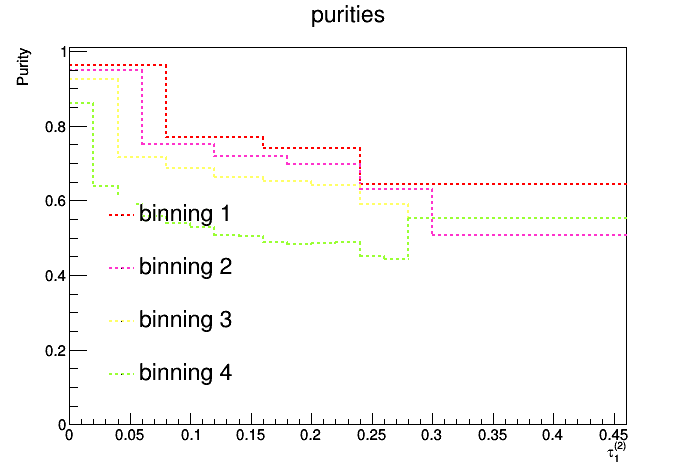

In [101]:
c=rt.TCanvas()
stack_purities.Draw("nostack")
stack_purities.GetXaxis().SetTitle("#tau_{1}^{(2)}")
stack_purities.GetYaxis().SetTitle("Purity")
stack_purities.Draw("nostack")
leg_purities.Draw("same")
c.Draw()

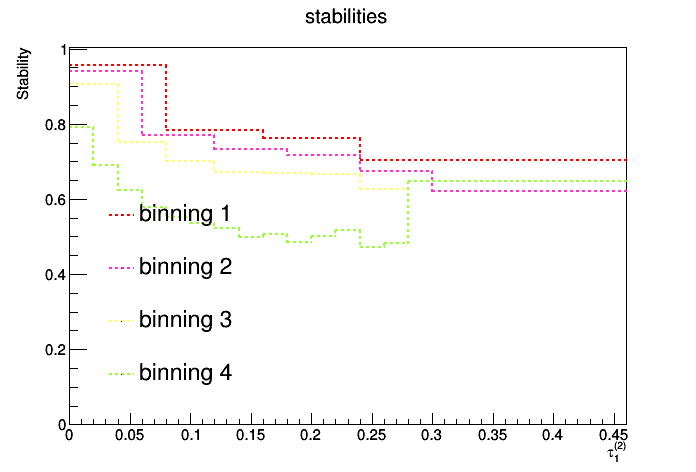

In [102]:
c=rt.TCanvas()
stack_stabilities.Draw("nostack")
stack_stabilities.GetXaxis().SetTitle("#tau_{1}^{(2)}")
stack_stabilities.GetYaxis().SetTitle("Stability")
stack_stabilities.Draw("nostack")
leg_stabilities.Draw("Same")
c.Draw()

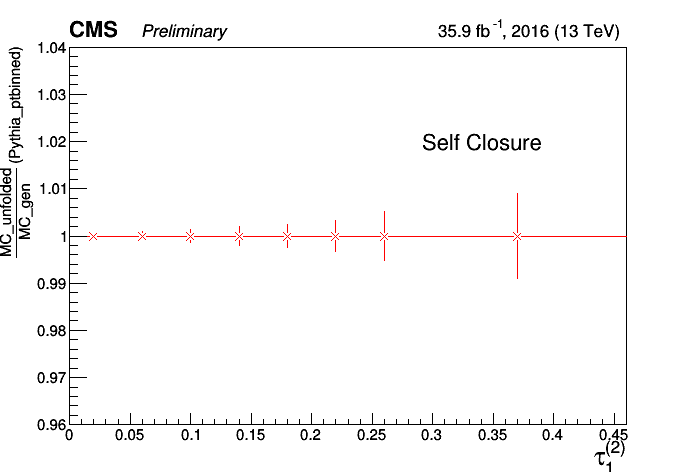

In [49]:
i=2
CMS_lumi.lumiTextSize=0.4
CMS_lumi.cmsTextSize=0.5
CMS_lumi.extraOverCmsTextSize=0.8
CMS_lumi.extraText="Preliminary"
CMS_lumi.lumi_13TeV=str(round((lumi/1000.),2))+" fb^{-1}, 2016 (13 TeV)"
CMS_lumi.relPosX=0.13
c=rt.TCanvas()
ratio_unfoldings[i].SetTitle("")
ratio_unfoldings[i].GetYaxis().SetRangeUser(0.96,1.04)
ratio_unfoldings[i].GetXaxis().SetTitleSize(0.06)
ratio_unfoldings[i].GetXaxis().SetTitleOffset(0.7)
ratio_unfoldings[i].Draw()
CMS_lumi.CMS_lumi(c,4,0)
leg=rt.TLegend(.6,.6,.9,.8,'Self Closure')
leg.SetLineColor(0)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetTextSize(0.05)
leg.Draw("Same")
c.Draw()

Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/Response_tau_2_0_dijetSel.png has been created
Info in <TCanvas::Print>: png file /t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/PurityStability_tau_2_0_dijetSel.png has been created


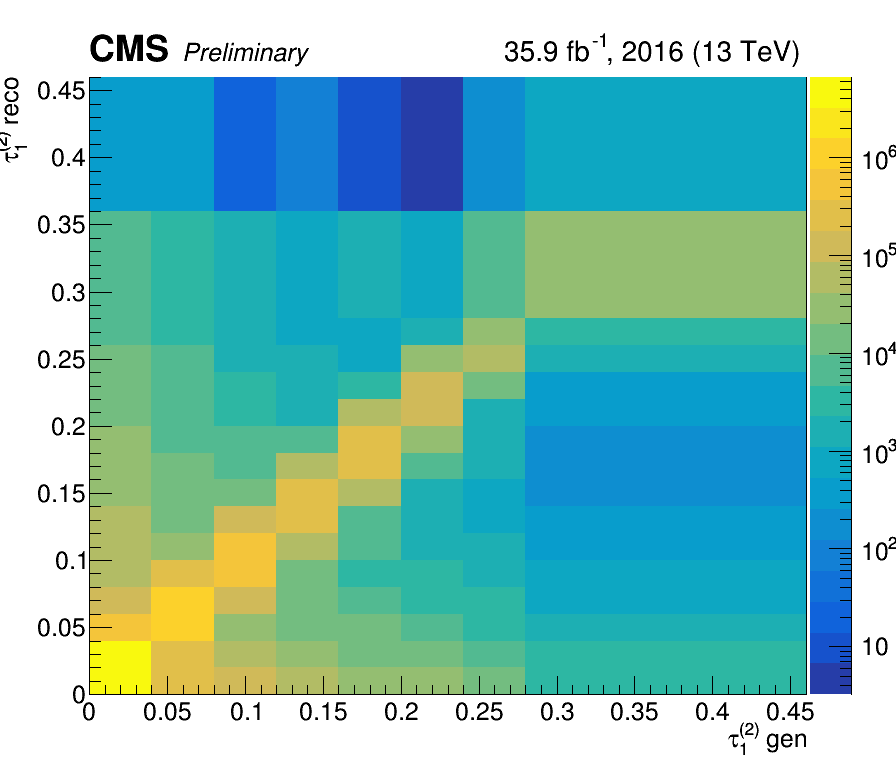

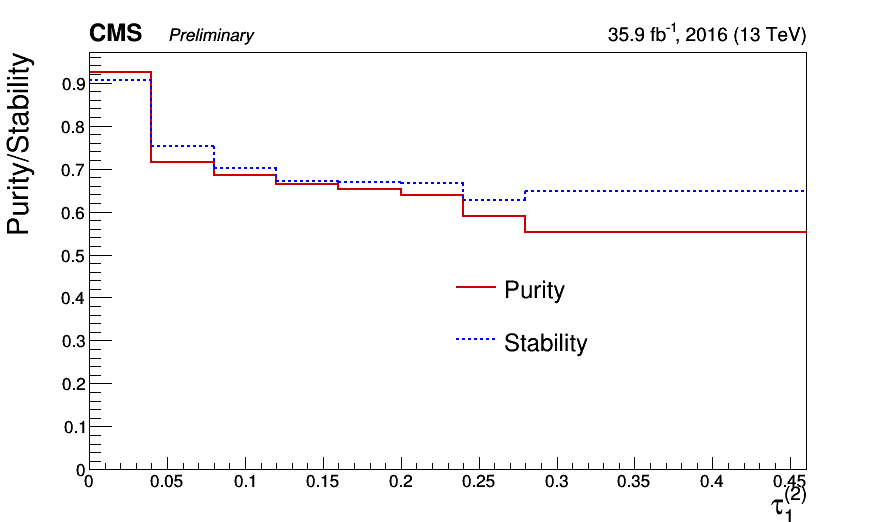

In [12]:
i=2
CMS_lumi.lumiTextSize=0.4
CMS_lumi.cmsTextSize=0.5
CMS_lumi.extraOverCmsTextSize=0.7
CMS_lumi.extraText="Preliminary"
CMS_lumi.lumi_13TeV=str(round((lumi/1000.),2))+" fb^{-1}, 2016 (13 TeV)"
CMS_lumi.relPosX=0.13
c1=rt.TCanvas("","",0,0,900,800)
c1.SetLogz()
responses[i].SetTitle("")
responses[i].Draw("Colz")
CMS_lumi.CMS_lumi(c1,4,0)
c1.Draw()
c1.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/Response_'+gen.split("t_")[1]+'.png')

CMS_lumi.relPosX=0.11
c2=rt.TCanvas("1","1",0,0,900,550)
ps=rt.THStack("","")
hist_purities[i].SetLineStyle(1)
hist_purities[i].SetLineColor(rt.kRed+1)
hist_stabilities[i].SetLineStyle(2)
hist_stabilities[i].SetLineColor(rt.kBlue)
ps.Add(hist_purities[i],"hist")
ps.Add(hist_stabilities[i],"hist")
ps.Draw("nostack")
#ps.GetXaxis().SetTitle("#tau_{1}^{(0.5)}")
ps.GetYaxis().SetTitle("Purity/Stability")
ps.GetYaxis().SetTitleSize(0.06)
ps.GetYaxis().SetTitleOffset(0.8)
ps.GetXaxis().SetTitle("#tau_{1}^{(2)}")
ps.GetXaxis().SetTitleSize(0.06)
ps.GetXaxis().SetTitleOffset(0.7)
leg=rt.TLegend(0.5,0.3,0.75,0.5)
leg.AddEntry(hist_purities[i],"Purity","l")
leg.AddEntry(hist_stabilities[i],"Stability","l")
leg.SetLineColor(0)
leg.SetBorderSize(0)
leg.SetFillStyle(0)
leg.SetTextSize(0.05)
leg.Draw("Same")
CMS_lumi.CMS_lumi(c2,4,0)
c2.Draw()
c2.SaveAs('/t3home/gelliu/Unfolding_Substructure/Figures/PurityStability/QCD_pythia8_ptbinned_dijetSel/PurityStability_'+gen.split("t_")[1]+'.png')